# Capstone Project - Property Prices in Paris

<i>By Sebastien Serville, February 2020</i>

## Introduction / Business Problem

I'm living in Paris (France) and as most of the big cities around the World one the biggest concerns for Parisians is to find a place to live. Apartment and house prices increased by 248% since 2000 (http://www.leparisien.fr/immobilier/10-000-euros-le-m2-a-paris-l-evolution-du-prix-de-l-immobilier-dans-la-capitale-5-graphiques-05-09-2019-8145984.php).
The aim of this project is to analyse the prices in Paris boroughs and districts and to identify venues available in each district. We will also look at the impact of the venues on the property prices. This analysis will be helpful for people who want to buy a property in Paris as it will provide the mean price per sqm and the most common venues in the neighborhood. It will help them to select the best locations based on their budget and the type of venues they are interested in (restaurants, museums, parks...). People looking at buying an investment property will also be interested in this analysis so they can buy a property at the best price and in a popular neighborhood.

## Data

To be able to complete this analysis, we will need to get the price of the properties (houses and apartments) recently sold. I decided to use data provided by the French government on the properties sold from 1st January 18 to 30th June 19. Data for the second half of 2019 is not yet available. 
1. <b>Paris Property Sales data</b> (csv file): It provides a list of properties sold in Paris between January 18 and June 19. Important fields are address, postcode, price, size, latitude, longitude, type of sales - https://www.data.gouv.fr/fr/datasets/5c4ae55a634f4117716d5656/#_
2. <b>Paris districts</b> (geojson file): It provides the list of Paris districts with geographical data (central point and polygon) https://www.data.gouv.fr/fr/datasets/arrondissements-1/
3. <b>Paris boroughs</b> (geojson file):It provides the list of Paris boroughs with geographical data (central point and polygon) https://www.data.gouv.fr/fr/datasets/quartiers-administratifs/
4. <b>Foursquare API</b> for location data: Foursquare provided location based services and they allow developers to get list of venues in a city, district or neighborhood. It will be used in this project to identify the number and type of venues available in a neighborhood - http://www.foursquare.com

By analysing and combining this data we will be able to define the mean property prices in Paris districts and to identify the venues that impact the most the prices. 

## Methodology

<b>1. Identify data sources:</b> Property prices in Paris by districts and / or by boroughs, Districts and boroughs of Paris with geospatial information, Venues data with their categories

<b>2. Prepare data:</b> Data cleansing and formatting

<b>3. Process and analyse data:</b> Use standard formulas to calculate mean price per sqm and number of sales by district and boroughs, Use data visualisation method (graphs, maps, tables…) to get insight from data, Use clustering method and machine learning to understand impact of venues on property prices 

<b>4. Review results and conclude</b>

## Data Analysis

### Import Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# for webscraping import Beautiful Soup 
#from bs4 import BeautifulSoup

import xml

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

import matplotlib.pyplot as plt
import json

!conda install -c conda-forge shapely
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following NEW packages will be 

### Upload, Cleanse and Format Housing Sales Data

#### Import csv files

In [2]:
# Read 2018 Housing Sales Price data for Paris
import types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_999f2e3388234f1b8664f97ccae4067b = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='B9b3Qv54q7nwpxT-nc5tIxCAgXw4Ml-h3Z4i08ON6UE0',
    ibm_auth_endpoint="https://iam.eu-gb.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_999f2e3388234f1b8664f97ccae4067b.get_object(Bucket='datascienceproject-donotdelete-pr-bcpjplsd6ye3xy',Key='75_2018.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_18 = pd.read_csv(body)

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:

body = client_999f2e3388234f1b8664f97ccae4067b.get_object(Bucket='datascienceproject-donotdelete-pr-bcpjplsd6ye3xy',Key='75_2019.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_19 = pd.read_csv(body)


#### Format dataframes and combine them

In [4]:
# Keep only relevant columns for 2019 and 2018 data
df_data_19 = df_data_19[['id_mutation','date_mutation','nature_mutation','valeur_fonciere','adresse_numero','adresse_nom_voie','code_postal','surface_reelle_bati','nombre_pieces_principales','longitude','latitude']]
df_data_18 = df_data_18[['id_mutation','date_mutation','nature_mutation','valeur_fonciere','adresse_numero','adresse_nom_voie','code_postal','surface_reelle_bati','nombre_pieces_principales','longitude','latitude']]

# Combine dataframe 2018 and 2019
df_data_price = pd.concat([df_data_18, df_data_19])

# Rename columns with meaningful names
df_data_price.columns = ['id','date','type','price','street_number','street','postcode','size','no_of_rooms','longitude','latitude']
df_data_price.head()

id       date   type      price  street_number  \
0  2018-1276175  4/01/2018  Vente  1202000.0             10   
1  2018-1276176  9/01/2018  Vente   130000.0             20   
2  2018-1276178  3/01/2018  Vente    15000.0             12   
3  2018-1276179  3/01/2018  Vente   650000.0            174   
4  2018-1276180  5/01/2018  Vente     3000.0            187   

                         street  postcode   size  no_of_rooms  longitude  \
0                    AV PERCIER     75008  120.0          2.0   2.315005   
1              RUE SAINT CLAUDE     75003   22.0          1.0   2.365335   
2                     RUE VOLTA     75003    9.0          1.0   2.357140   
3                  BD HAUSSMANN     75008   96.0          3.0   2.307897   
4  RUE DU FAUBOURG SAINT HONORE     75008   58.0          3.0   2.304125   

    latitude  
0  48.874705  
1  48.860248  
2  48.864804  
3  48.875379  
4  48.875332

#### Data cleanse

In [5]:
# Check unique type of sales
df_data_price.type.unique()

array(['Vente', 'Vente terrain a\xa0 batir', 'Echange', 'Adjudication',
       "Vente en l'etat futur d'achevement", 'Expropriation'],
      dtype=object)

In [6]:
# Only sales are required (type = Vente) so we remove other values
df_data_price = df_data_price.query("type == 'Vente'")

# Sort by price ascending
df_data_price.sort_values(by=['price'],ascending=[True],inplace=True)

# Remove sales where price is below 10,000 Euro
df_data_price = df_data_price.query("price > 10000")

# Sort by price descending
df_data_price.sort_values(by=['price'],ascending=[False],inplace=True)

# Remove sales where price is greater than 100,000,000 Euro
df_data_price = df_data_price.query("price < 100000000")
df_data_price.shape


(43052, 11)

#### Analyse Price per Sqm

In [9]:
# Add price per sqm column
df_data_test = df_data_price
df_data_price['price_sqm'] = df_data_price['price']/df_data_price['size']
df_data_price.head()

id        date   type       price  street_number  \
32020  2018-1306395       43455  Vente  91600000.0            167   
2341   2018-1279594  19/03/2018  Vente  88000000.0            154   
30673  2018-1278757       43439  Vente  81460000.0            376   
30752  2018-1280052       43224  Vente  80000000.0             87   
31988  2018-1305782       43412  Vente  75976912.0             83   

                    street  postcode    size  no_of_rooms  longitude  \
32020       BD MALESHERBES     75017  9221.0          3.0   2.305318   
2341   RUE DE L UNIVERSITE     75007   110.0          2.0   2.307842   
30673     RUE SAINT HONORE     75001   190.0          3.0   2.326548   
30752      RUE DE GRENELLE     75007  1427.0         21.0   2.321221   
31988   RUE PIERRE DEMOURS     75017  6494.0          5.0   2.299383   

        latitude      price_sqm  
32020  48.885983    9933.846654  
2341   48.861426  800000.000000  
30673  48.867501  428736.842105  
30752  48.855606   56061.667835  
31988  48.883968   11699.555282

In [10]:
# Check nan values
df_data_price.isnull().sum()

id                0
date              0
type              0
price             0
street_number     0
street            0
postcode          0
size              1
no_of_rooms       1
longitude        10
latitude         10
price_sqm         1
dtype: int64

In [11]:
# Drop nan values
df_data_price.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)


# Change format of column price_sqm
df_data_price['price_sqm'] = df_data_price['price_sqm'].astype('int64')
df_data_price.head()

id        date   type       price  street_number  \
32020  2018-1306395       43455  Vente  91600000.0            167   
2341   2018-1279594  19/03/2018  Vente  88000000.0            154   
30673  2018-1278757       43439  Vente  81460000.0            376   
30752  2018-1280052       43224  Vente  80000000.0             87   
31988  2018-1305782       43412  Vente  75976912.0             83   

                    street  postcode    size  no_of_rooms  longitude  \
32020       BD MALESHERBES     75017  9221.0          3.0   2.305318   
2341   RUE DE L UNIVERSITE     75007   110.0          2.0   2.307842   
30673     RUE SAINT HONORE     75001   190.0          3.0   2.326548   
30752      RUE DE GRENELLE     75007  1427.0         21.0   2.321221   
31988   RUE PIERRE DEMOURS     75017  6494.0          5.0   2.299383   

        latitude  price_sqm  
32020  48.885983       9933  
2341   48.861426     800000  
30673  48.867501     428736  
30752  48.855606      56061  
31988  48.883968      11699

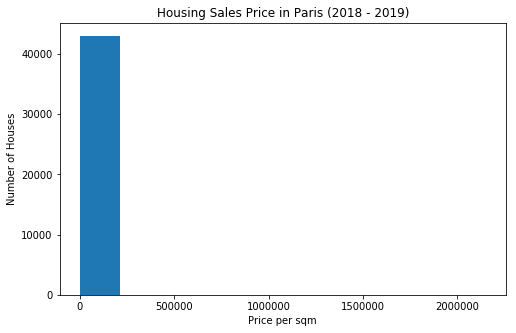

In [12]:
# Check distribution of price per sqm
count, bin_edges = np.histogram(df_data_price['price_sqm'])

df_data_price['price_sqm'].plot(kind='hist', figsize=(8, 5))

plt.title('Housing Sales Price in Paris (2018 - 2019)') # add a title to the histogram
plt.ylabel('Number of Houses') # add y-label
plt.xlabel('Price per sqm') # add x-label

plt.show()

In [13]:
# Remove sales where price per sqm is below 1000 Euro per sqm and above 50000 Euro per sqm
df_data_price = df_data_price.query("price_sqm > 1000")
df_data_price = df_data_price.query("price_sqm < 50000")
df_data_price.shape

(42570, 12)

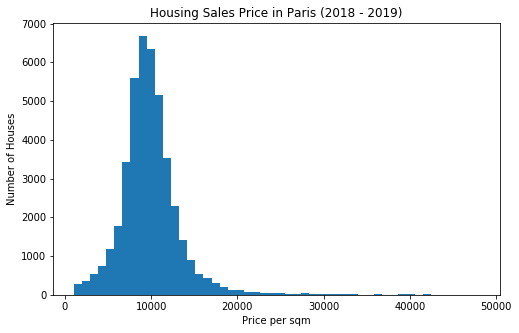

In [14]:
# Show distribution on an histogram
df_data_price['price_sqm'].plot(kind='hist', figsize=(8, 5), bins=50)

plt.title('Housing Sales Price in Paris (2018 - 2019)') # add a title to the histogram
plt.ylabel('Number of Houses') # add y-label
plt.xlabel('Price per sqm') # add x-label

plt.show()

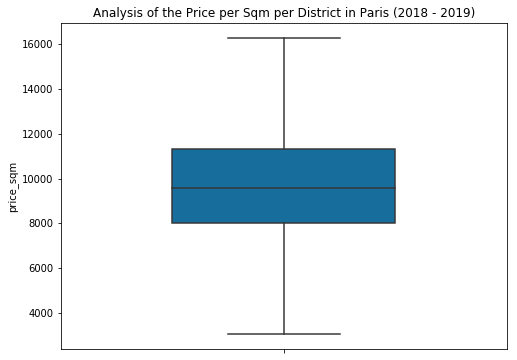

In [15]:
# Create boxplot chart to analyse price per sqm
import seaborn as sns
plt.figure(figsize=(8, 6))
plt.title('Analysis of the Price per Sqm per District in Paris (2018 - 2019)')
sns.boxplot(y='price_sqm',  
                 data=df_data_price, 
                 width=0.5,
                 palette="colorblind",
                 showfliers=False)

### Analyse data by district

In [16]:
# Show all districts (postcode)
df_data_price['postcode'].unique()

array([75017, 75007, 75012, 75015, 75016, 75008, 75009, 75010, 75001,
       75004, 75018, 75005, 75019, 75006, 75011, 75002, 75013, 75003,
       75020, 75014])

#### Mean Price

In [17]:
# Check mean price by district
df_district = df_data_price[['id','postcode','price_sqm']]
df_district_mean = df_district.groupby(['postcode'],as_index=False).mean()
df_district_mean

postcode     price_sqm
0      75001  12366.262877
1      75002  10993.985093
2      75003  11504.805774
3      75004  13063.114352
4      75005  11538.165771
5      75006  14046.468777
6      75007  13983.240870
7      75008  12001.793679
8      75009  10424.546952
9      75010   9547.470287
10     75011   9570.311263
11     75012   8830.594579
12     75013   8585.378523
13     75014   9615.394660
14     75015   9212.241322
15     75016  10657.449517
16     75017   9950.332647
17     75018   8766.340352
18     75019   7957.844889
19     75020   8175.498111

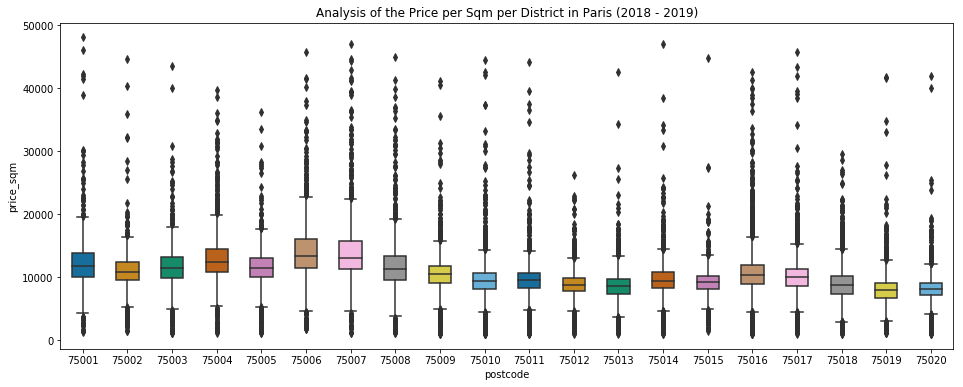

In [18]:
# Create boxplot chart to analyse price per sqm per district
df_district = df_data_price[['postcode','price_sqm']]

import seaborn as sns
plt.figure(figsize=(16, 6))
plt.title('Analysis of the Price per Sqm per District in Paris (2018 - 2019)')
sns.boxplot(y='price_sqm', x='postcode', 
                 data=df_district, 
                 width=0.5,
                 palette="colorblind")

#### Mean size of apartments by district

In [19]:
df_district = df_data_price[['id','postcode','size']]
df_district_size = df_district.groupby(['postcode'],as_index=False).median()
df_district_size

postcode  size
0      75001  40.0
1      75002  37.0
2      75003  40.0
3      75004  43.0
4      75005  39.0
5      75006  54.0
6      75007  62.0
7      75008  70.0
8      75009  46.0
9      75010  40.0
10     75011  37.0
11     75012  44.0
12     75013  42.0
13     75014  42.0
14     75015  45.0
15     75016  75.0
16     75017  46.0
17     75018  36.0
18     75019  43.0
19     75020  40.0

([<matplotlib.axis.XTick at 0x7efed1ecb0f0>,
 <a list of 20 Text xticklabel objects>)

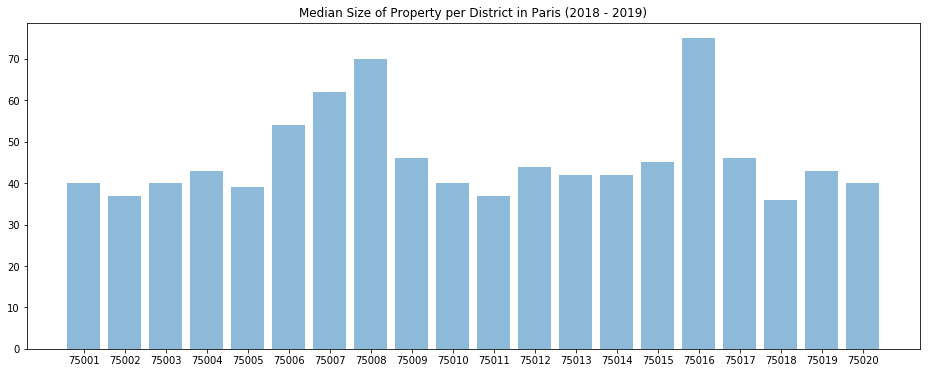

In [20]:
# Create bar chart to show mean size of apartments by district
plt.figure(figsize=(16, 6))
plt.title('Median Size of Property per District in Paris (2018 - 2019)')
plt.bar(df_district_size['postcode'], df_district_size['size'], align='center', alpha=0.5)
plt.xticks(df_district_size['postcode'])

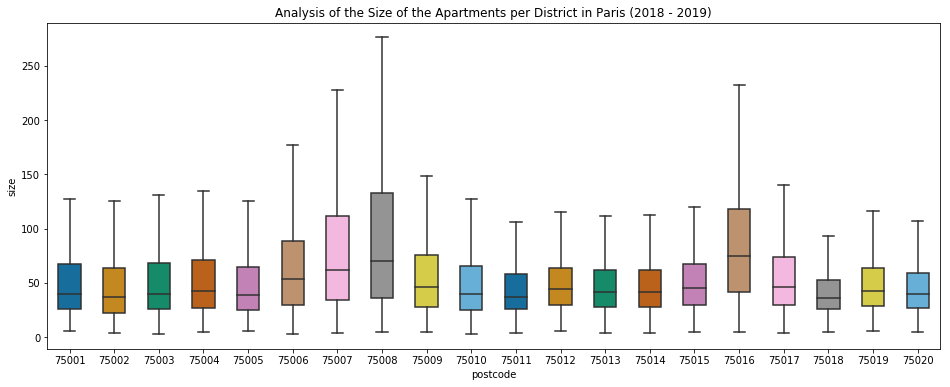

In [21]:
# Create boxplot chart to analyse size of apartments per district
import seaborn as sns
plt.figure(figsize=(16, 6))
plt.title('Analysis of the Size of the Apartments per District in Paris (2018 - 2019)')
sns.boxplot(y='size', x='postcode', 
                 data=df_district, 
                 width=0.5,
                 palette="colorblind",
                 showfliers=False)

#### Number of Sales by district

In [22]:
df_district_cnt = df_data_price[['id','postcode']]
df_district_cnt = df_district_cnt.groupby(['postcode'],as_index=False).count()
df_district_cnt

postcode    id
0      75001   563
1      75002   805
2      75003  1143
3      75004   857
4      75005  1116
5      75006  1137
6      75007  1287
7      75008  1139
8      75009  1821
9      75010  2541
10     75011  2628
11     75012  1697
12     75013  2235
13     75014  2397
14     75015  1210
15     75016  4140
16     75017  4371
17     75018  5509
18     75019  2798
19     75020  3176

([<matplotlib.axis.XTick at 0x7efed1d19e48>,
 <a list of 20 Text xticklabel objects>)

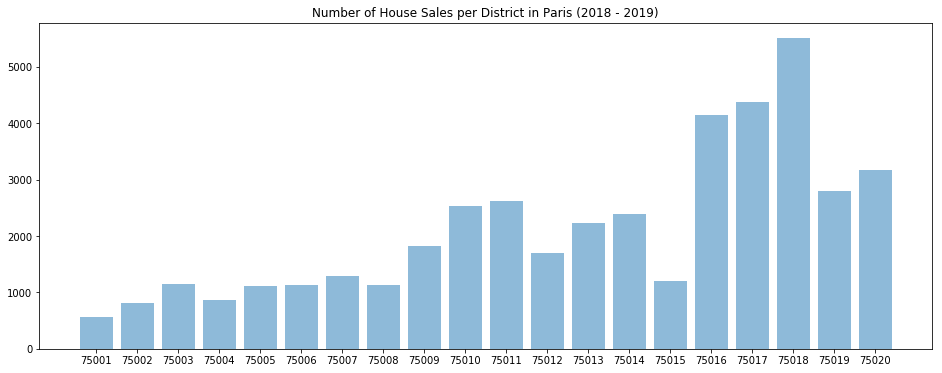

In [23]:
# Create bar chart to show number of sales by district
plt.figure(figsize=(16, 6))
plt.title('Number of House Sales per District in Paris (2018 - 2019)')
plt.bar(df_district_cnt['postcode'], df_district_cnt['id'], align='center', alpha=0.5)
plt.xticks(df_district_cnt['postcode'])

### Show Data on Maps

In [24]:
# Download json file with Paris districts
!wget --quiet https://www.data.gouv.fr/fr/datasets/r/4765fe48-35fd-4536-b029-4727380ce23c -O Paris_Districts.geojson

print("GeoJson file downloaded")

GeoJson file downloaded


In [68]:
import json

Paris_geo = json.load(open("Paris_Districts.geojson"))

# Create test map with Paris districts
paris_map_district = folium.Map(location=[48.861472, 2.347581], zoom_start=13, tiles='cartodbpositron')
paris_map_district.choropleth(geo_data=Paris_geo)
paris_map_district

In [70]:
# Add District number in df_district_mean dataframe
df_district_mean['district_no'] = df_district_mean['postcode'] - 75000

# Generate choropleth map using the price per sqm for all Paris districts
paris_map = folium.Map(location=[48.861472, 2.347581], zoom_start=13, tiles='cartodbpositron')

paris_map.choropleth(
    geo_data=Paris_geo,
    data=df_district_mean,
    columns=['district_no', 'price_sqm'],
    key_on="feature.properties.c_ar",
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.2,
    legend_name = 'Housing Sales Price per Sqm (2018 - 2019)'
)

# display map
paris_map

In [71]:
# Add District number in df_district_cnt dataframe
df_district_cnt['district_no'] = df_district_cnt['postcode'] - 75000

# generate choropleth map using the number of sales for all Paris districts
paris_map_cnt = folium.Map(location=[48.861472, 2.347581], zoom_start=13, tiles='cartodbpositron')

paris_map_cnt.choropleth(
    geo_data=Paris_geo,
    data=df_district_cnt,
    columns=['district_no', 'id'],
    key_on="feature.properties.c_ar",
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.2,
    legend_name = 'Number of Sales by District (2018 - 2019)'
)

# display map
paris_map_cnt

### Identify Paris Boroughs

#### Get Paris Boroughs

In [30]:
# Download json file with Paris boroughs
!wget --quiet https://www.data.gouv.fr/fr/datasets/r/a8748f53-5850-4a04-b8cc-9c9f5f72949f -O Paris_Boroughs.geojson

print("GeoJson file downloaded")

GeoJson file downloaded


In [72]:
Paris_boroughs = json.load(open("Paris_Boroughs.geojson"))

# Create test map with Paris boroughs
paris_map2 = folium.Map(location=[48.861472, 2.347581], zoom_start=13, tiles='cartodbpositron')
paris_map2.choropleth(geo_data=Paris_boroughs)
paris_map2

In [33]:
# Create dataframe with boroughs details
df_boroughs = pd.DataFrame({
    "id" : [brg["properties"]["c_qu"] for brg in Paris_boroughs["features"]],
    "name" : [brg["properties"]["l_qu"] for brg in Paris_boroughs["features"]], 
    "district" : [brg["properties"]["c_ar"] for brg in Paris_boroughs["features"]],
    "geom_x_y" : [brg["properties"]["geom_x_y"] for brg in Paris_boroughs["features"]],
    "polygon" : [brg["geometry"]["coordinates"] for brg in Paris_boroughs["features"]]
})
df_boroughs.sort_values(by=['id'],ascending=[True],inplace=True)
df_boroughs.head()

id                       name  district                        geom_x_y  \
64   1  Saint-Germain-l'Auxerrois         1  [48.8606501352, 2.33491032928]   
47   2                     Halles         1  [48.8622891081, 2.34489885831]   
8    3               Palais-Royal         1  [48.8646599781, 2.33630891897]   
34   4              Place-Vendôme         1  [48.8670185906, 2.32858166493]   
72   5                    Gaillon         2  [48.8693066381, 2.33343180766]   

                                              polygon  
64  [[[2.344593389828428, 48.85404991486193], [2.3...  
47  [[[2.349365804803003, 48.86057567227664], [2.3...  
8   [[[2.339465868602756, 48.86213531210705], [2.3...  
34  [[[2.3319449693932333, 48.86491285292421], [2....  
72  [[[2.336320212305948, 48.8679713890312], [2.33...

#### Add Paris Boroughs in Sales Dataframe

Boroughs are not available in our Sales dataset so we need to add them in it by checking in which borough a property is located. We will use the latitude and longitude of the property and test if it is located in a borough by using is geospatial representation (polygon). We use the library named Shapely to check if a point is in a polygon.

In [39]:
# Install shapely to check in which borough a property is located
!conda install -c conda-forge shapely

Solving environment: done

# All requested packages already installed.



In [34]:
# Add district number in our dataset
df_data_price['district'] = df_data_price['postcode'] - 75000
df_data_price.head()

id   date   type       price  street_number  \
32020  2018-1306395  43455  Vente  91600000.0            167   
31988  2018-1305782  43412  Vente  75976912.0             83   
30765  2018-1280223  43223  Vente  68000000.0              6   
31187  2018-1288306  43187  Vente  51340000.0            157   
31595  2018-1297564  43187  Vente  51010000.0            106   

                      street  postcode    size  no_of_rooms  longitude  \
32020         BD MALESHERBES     75017  9221.0          3.0   2.305318   
31988     RUE PIERRE DEMOURS     75017  6494.0          5.0   2.299383   
30765       RUE ST DOMINIQUE     75007  3344.0          6.0   2.322747   
31187           AV DAUMESNIL     75012  6725.0          1.0   2.388375   
31595  RUE OLIVIER DE SERRES     75015  6928.0          5.0   2.292484   

        latitude  price_sqm  district  
32020  48.885983       9933        17  
31988  48.883968      11699        17  
30765  48.858435      20334         7  
31187  48.841467       7634        12  
31595  48.832376       7362        15

In [35]:
# Add new columns for borough id and borough name
df_data_price['borough_id'] = ''
df_data_price['borough_name'] = ''

In [36]:
# Identify the borough of each property available in our dataset
df_results = []
for lat, lng, dist_bor in zip(df_data_price.latitude, df_data_price.longitude, df_data_price.district):
    for bor_id, bor_name, bor_dist, bor_poly in zip(df_boroughs.id, df_boroughs.name, df_boroughs.district, df_boroughs.polygon):
        if dist_bor == bor_dist:
            point= Point(lng,lat)
            polygon = Polygon(bor_poly[0])
            if polygon.contains(point):
                df_results.append([bor_id, bor_name])

df_data_price[['borough_id','borough_name']] = df_results
df_data_price.head()

id   date   type       price  street_number  \
32020  2018-1306395  43455  Vente  91600000.0            167   
31988  2018-1305782  43412  Vente  75976912.0             83   
30765  2018-1280223  43223  Vente  68000000.0              6   
31187  2018-1288306  43187  Vente  51340000.0            157   
31595  2018-1297564  43187  Vente  51010000.0            106   

                      street  postcode    size  no_of_rooms  longitude  \
32020         BD MALESHERBES     75017  9221.0          3.0   2.305318   
31988     RUE PIERRE DEMOURS     75017  6494.0          5.0   2.299383   
30765       RUE ST DOMINIQUE     75007  3344.0          6.0   2.322747   
31187           AV DAUMESNIL     75012  6725.0          1.0   2.388375   
31595  RUE OLIVIER DE SERRES     75015  6928.0          5.0   2.292484   

        latitude  price_sqm  district  borough_id        borough_name  
32020  48.885983       9933        17          66  Plaine de Monceaux  
31988  48.883968      11699        17          66  Plaine de Monceaux  
30765  48.858435      20334         7          26           Invalides  
31187  48.841467       7634        12          46              Picpus  
31595  48.832376       7362        15          57       Saint-Lambert

In [37]:
# Get some stats about our dataset
df_data_price.describe()

price  street_number      postcode          size   no_of_rooms  \
count  4.257000e+04   42570.000000  42570.000000  42570.000000  42570.000000   
mean   6.223782e+05      46.749753  75013.337515     62.015128      2.390721   
std    1.315786e+06      53.468367      5.156784    138.697489      1.325097   
min    1.150000e+04       1.000000  75001.000000      3.000000      0.000000   
25%    2.500000e+05      11.000000  75010.000000     28.000000      1.000000   
50%    4.000000e+05      27.000000  75014.000000     44.000000      2.000000   
75%    6.700000e+05      63.000000  75018.000000     70.000000      3.000000   
max    9.160000e+07     416.000000  75020.000000  10601.000000     23.000000   

          longitude      latitude     price_sqm      district    borough_id  
count  42570.000000  42570.000000  42570.000000  42570.000000  42570.000000  
mean       2.342387     48.865085   9903.078389     13.337515     51.821776  
std        0.036485      0.019995   3605.010137      5.156784     20.548900  
min        2.255896     48.819411   1014.000000      1.000000      1.000000  
25%        2.319932     48.850248   8000.000000     10.000000     38.000000  
50%        2.345053     48.867434   9576.000000     14.000000     56.000000  
75%        2.369472     48.882477  11317.000000     18.000000     69.000000  
max        2.412825     48.900565  48050.000000     20.000000     80.000000

### Analyse data by Borough

#### Get mean prices

In [73]:
# Calculate mean price by borough
df_borough_mean = df_data_price[['id','borough_name','price_sqm']]
df_borough_mean = df_borough_mean.groupby(['borough_name'],as_index=False).mean()

# generate choropleth map using the price per sqm for all Paris boroughs
paris_map2.choropleth(
    geo_data=Paris_boroughs,
    data=df_borough_mean,
    columns=['borough_name', 'price_sqm'],
    key_on="feature.properties.l_qu",
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.2,
    legend_name = 'Housing Sales Price per Sqm per Borough (2018 - 2019)'
)

# display map
paris_map2

#### Number of Sales by Borough

([<matplotlib.axis.XTick at 0x7efed27bd828>,
 <a list of 80 Text xticklabel objects>)

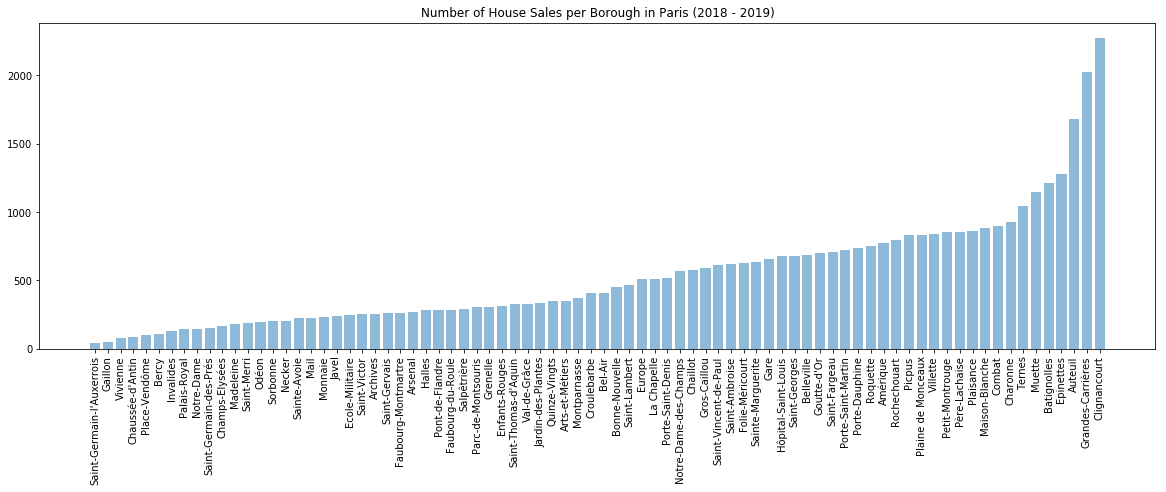

In [39]:
# Calculate number of sales by borough
df_borough_cnt = df_data_price[['id','borough_name']]
df_borough_cnt = df_borough_cnt.groupby(['borough_name'],as_index=False).count()
df_borough_cnt.sort_values(by=['id'],ascending=[True],inplace=True)

# Show number of sales by borough on a bar chart
plt.figure(figsize=(20, 6))
plt.title('Number of House Sales per Borough in Paris (2018 - 2019)')
plt.bar(df_borough_cnt['borough_name'], df_borough_cnt['id'], align='center', alpha=0.5)
plt.xticks(df_borough_cnt['borough_name'], rotation='vertical')

In [75]:
# generate choropleth map using the number of sales for all Paris boroughs
paris_map3 = folium.Map(location=[48.861472, 2.347581], zoom_start=13, tiles='cartodbpositron')
paris_map3.choropleth(
    geo_data=Paris_boroughs,
    data=df_borough_cnt,
    columns=['borough_name', 'cnt'],
    key_on="feature.properties.l_qu",
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name = 'Number of Sales per Borough (2018 - 2019)'
)

# display map
paris_map3

#### Get Apartment Size by Borough

([<matplotlib.axis.XTick at 0x7efed0447908>,
 <a list of 80 Text xticklabel objects>)

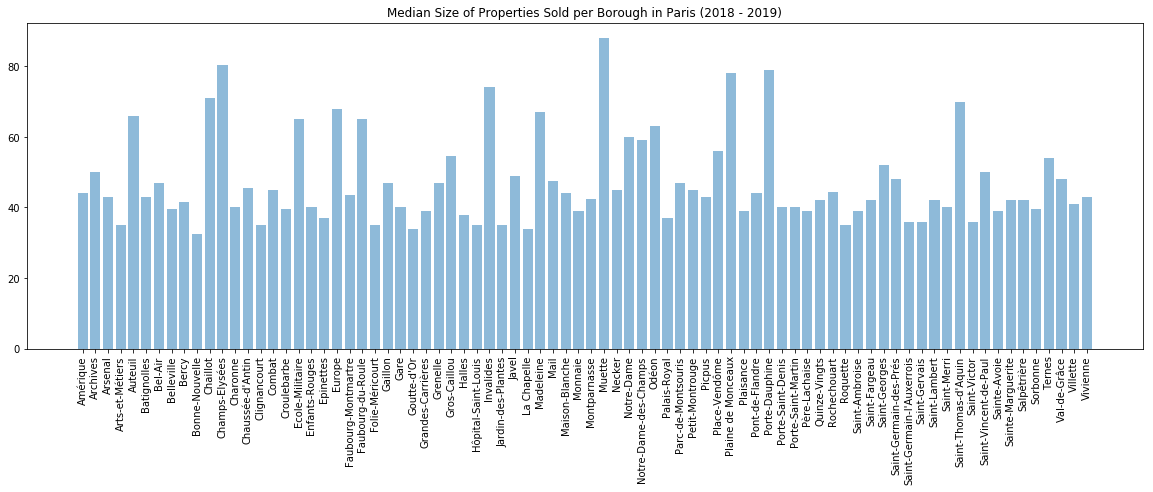

In [41]:
# Calculate median size of apartment by borough
df_borough_size = df_data_price[['id','borough_name','size']]
df_borough_size = df_borough_size.groupby(['borough_name'],as_index=False).median()
df_borough_size.head()

# Show median sze of apartment by borough on a bar chart
plt.figure(figsize=(20, 6))
plt.title('Median Size of Properties Sold per Borough in Paris (2018 - 2019)')
plt.bar(df_borough_size['borough_name'], df_borough_size['size'], align='center', alpha=0.5)
plt.xticks(df_borough_size['borough_name'], rotation='vertical')

In [76]:
# generate choropleth map using the median size of apartments for all Paris boroughs
paris_map4 = folium.Map(location=[48.861472, 2.347581], zoom_start=13, tiles='cartodbpositron')
paris_map4.choropleth(
    geo_data=Paris_boroughs,
    data=df_borough_size,
    columns=['borough_name', 'size'],
    key_on="feature.properties.l_qu",
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name = 'Median Property Size per Borough (2018 - 2019)'
)

# display map
paris_map4

We will use Foursquare API to get venues in each neighborhood and to identify the most common venues in each of them.

#### Define settings and functions

In [47]:
CLIENT_ID = '' # your Foursquare ID HIDDEN
CLIENT_SECRET = '' # your Foursquare Secret HIDDEN
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PRMNCISXL23PWSZDCQEZJRQSZSGBEFOU5CFXLFUQL2M5HVSN
CLIENT_SECRET:SLLLONSIBLSOVLK3N2IOIQD2KWJVG0D2X4PL4FDCQLEDEJHY


In [44]:
# Function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [45]:
# Function that gets venus from FourSquare and store results in dataframe
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name, lat, lng)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [46]:
# Function that sorts Venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Get Venues

In [49]:
LIMIT = 100
radius = 500

# Add latitude and longitude in Boroughs dataframe as separate columns
lat_long = pd.DataFrame(df_boroughs['geom_x_y'].tolist(), index=df_boroughs.index)
lat_long.columns = ['latitude','longitude']
df_boroughs[['latitude','longitude']] = lat_long
df_boroughs.head()

id                       name  district                        geom_x_y  \
64   1  Saint-Germain-l'Auxerrois         1  [48.8606501352, 2.33491032928]   
47   2                     Halles         1  [48.8622891081, 2.34489885831]   
8    3               Palais-Royal         1  [48.8646599781, 2.33630891897]   
34   4              Place-Vendôme         1  [48.8670185906, 2.32858166493]   
72   5                    Gaillon         2  [48.8693066381, 2.33343180766]   

                                              polygon   latitude  longitude  
64  [[[2.344593389828428, 48.85404991486193], [2.3...  48.860650   2.334910  
47  [[[2.349365804803003, 48.86057567227664], [2.3...  48.862289   2.344899  
8   [[[2.339465868602756, 48.86213531210705], [2.3...  48.864660   2.336309  
34  [[[2.3319449693932333, 48.86491285292421], [2....  48.867019   2.328582  
72  [[[2.336320212305948, 48.8679713890312], [2.33...  48.869307   2.333432

In [50]:
# Get top 100 venues in each neighborhood using a 500 meters radius and add them in a dataframe
paris_venues = getNearbyVenues(names=df_boroughs['name'],
                                   latitudes=df_boroughs['latitude'],
                                   longitudes=df_boroughs['longitude']
                                  )

Saint-Germain-l'Auxerrois 48.8606501352 2.33491032928
Halles 48.8622891081 2.34489885831
Palais-Royal 48.8646599781 2.33630891897
Place-Vendôme 48.8670185906 2.32858166493
Gaillon 48.8693066381 2.33343180766
Vivienne 48.8691001998 2.33946074375
Mail 48.8680083374 2.34469912743
Bonne-Nouvelle 48.8671501183 2.35008019041
Arts-et-Métiers 48.8664702895 2.35708313106
Enfants-Rouges 48.863887392 2.36312330099
Archives 48.8591924127 2.36320505733
Sainte-Avoie 48.862557245 2.35485151825
Saint-Merri 48.8585213723 2.35166696714
Saint-Gervais 48.8557186509 2.35816233385
Arsenal 48.851585175 2.36476795387
Notre-Dame 48.8528955862 2.35277501212
Saint-Victor 48.8476636355 2.35409315338
Jardin-des-Plantes 48.8419401934 2.35689388962
Val-de-Grâce 48.841684288 2.34386092632
Sorbonne 48.8490447659 2.34574660019
Monnaie 48.8543844036 2.34003537113
Odéon 48.8478006293 2.33633882759
Notre-Dame-des-Champs 48.846427594 2.32735687823
Saint-Germain-des-Prés 48.85528872 2.33365686809
Saint-Thomas-d'Aquin 48.855

In [51]:
# Check results for Foursquare API call
print(paris_venues.shape)
paris_venues.head()

(5470, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Saint-Germain-l'Auxerrois               48.86065                 2.33491   
1  Saint-Germain-l'Auxerrois               48.86065                 2.33491   
2  Saint-Germain-l'Auxerrois               48.86065                 2.33491   
3  Saint-Germain-l'Auxerrois               48.86065                 2.33491   
4  Saint-Germain-l'Auxerrois               48.86065                 2.33491   

                                               Venue  Venue Latitude  \
0                                    Musée du Louvre       48.860847   
1                   La Vénus de Milo (Vénus de Milo)       48.859943   
2                 Vestige de la Forteresse du Louvre       48.861577   
3                                      Cour Napoléon       48.861172   
4  Pavillon des Sessions – Arts d'Afrique, d'Asie...       48.860724   

   Venue Longitude Venue Category  
0         2.336440     Art Museum  
1         2.337234        Exhibit  
2         2.333508  Historic Site  
3         2.335088          Plaza  
4         2.332121     Art Museum

([<matplotlib.axis.XTick at 0x7efed01f3f98>,
 <a list of 80 Text xticklabel objects>)

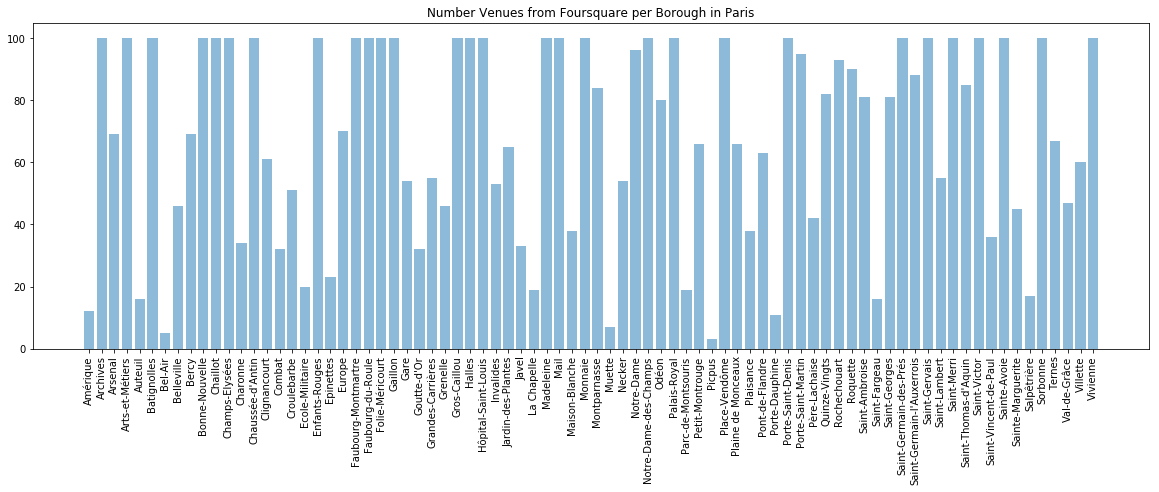

In [52]:
# Check number of venues retrieved by boroughs
df_venues_cnt = paris_venues[['Venue','Neighborhood']]
df_venues_cnt = df_venues_cnt.groupby(['Neighborhood'],as_index=False).count()
df_venues_cnt.sort_values(by=['Neighborhood'],ascending=[True],inplace=True)

# Show number of venues by borough on a bar chart
plt.figure(figsize=(20, 6))
plt.title('Number Venues from Foursquare per Borough in Paris')
plt.bar(df_venues_cnt['Neighborhood'], df_venues_cnt['Venue'], align='center', alpha=0.5)
plt.xticks(df_venues_cnt['Neighborhood'], rotation='vertical')

There is a limited number of venues in some boroughs (Bel-Air, Muette, Picpus) because of where the central point is located (in parks). Let's update the central point for these boroughs.

In [55]:
# Update Picpus geospatial coordinates
df_boroughs['latitude'][16] = 48.839388
df_boroughs['longitude'][16] = 2.395743

# Update Bel-Air geospatial coordinates
df_boroughs['latitude'][58] = 48.840247
df_boroughs['longitude'][58] = 2.407823

# Update Muette geospatial coordinates
df_boroughs['latitude'][77] = 48.860060
df_boroughs['longitude'][77] = 2.265865

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ip

In [56]:
# Get top 100 venues in each neighborhood using a 500 meters radius and add them in a dataframe
paris_venues = getNearbyVenues(names=df_boroughs['name'],
                                   latitudes=df_boroughs['latitude'],
                                   longitudes=df_boroughs['longitude']
                                  )

Saint-Germain-l'Auxerrois 48.8606501352 2.33491032928
Halles 48.8622891081 2.34489885831
Palais-Royal 48.8646599781 2.33630891897
Place-Vendôme 48.8670185906 2.32858166493
Gaillon 48.8693066381 2.33343180766
Vivienne 48.8691001998 2.33946074375
Mail 48.8680083374 2.34469912743
Bonne-Nouvelle 48.8671501183 2.35008019041
Arts-et-Métiers 48.8664702895 2.35708313106
Enfants-Rouges 48.863887392 2.36312330099
Archives 48.8591924127 2.36320505733
Sainte-Avoie 48.862557245 2.35485151825
Saint-Merri 48.8585213723 2.35166696714
Saint-Gervais 48.8557186509 2.35816233385
Arsenal 48.851585175 2.36476795387
Notre-Dame 48.8528955862 2.35277501212
Saint-Victor 48.8476636355 2.35409315338
Jardin-des-Plantes 48.8419401934 2.35689388962
Val-de-Grâce 48.841684288 2.34386092632
Sorbonne 48.8490447659 2.34574660019
Monnaie 48.8543844036 2.34003537113
Odéon 48.8478006293 2.33633882759
Notre-Dame-des-Champs 48.846427594 2.32735687823
Saint-Germain-des-Prés 48.85528872 2.33365686809
Saint-Thomas-d'Aquin 48.855

In [57]:
# Check results for Foursquare API call
print(paris_venues.shape)
paris_venues.head()

(5527, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Saint-Germain-l'Auxerrois               48.86065                 2.33491   
1  Saint-Germain-l'Auxerrois               48.86065                 2.33491   
2  Saint-Germain-l'Auxerrois               48.86065                 2.33491   
3  Saint-Germain-l'Auxerrois               48.86065                 2.33491   
4  Saint-Germain-l'Auxerrois               48.86065                 2.33491   

                                               Venue  Venue Latitude  \
0                                    Musée du Louvre       48.860847   
1                   La Vénus de Milo (Vénus de Milo)       48.859943   
2                 Vestige de la Forteresse du Louvre       48.861577   
3                                      Cour Napoléon       48.861172   
4  Pavillon des Sessions – Arts d'Afrique, d'Asie...       48.860724   

   Venue Longitude Venue Category  
0         2.336440     Art Museum  
1         2.337234        Exhibit  
2         2.333508  Historic Site  
3         2.335088          Plaza  
4         2.332121     Art Museum

([<matplotlib.axis.XTick at 0x7efdf7606518>,
 <a list of 80 Text xticklabel objects>)

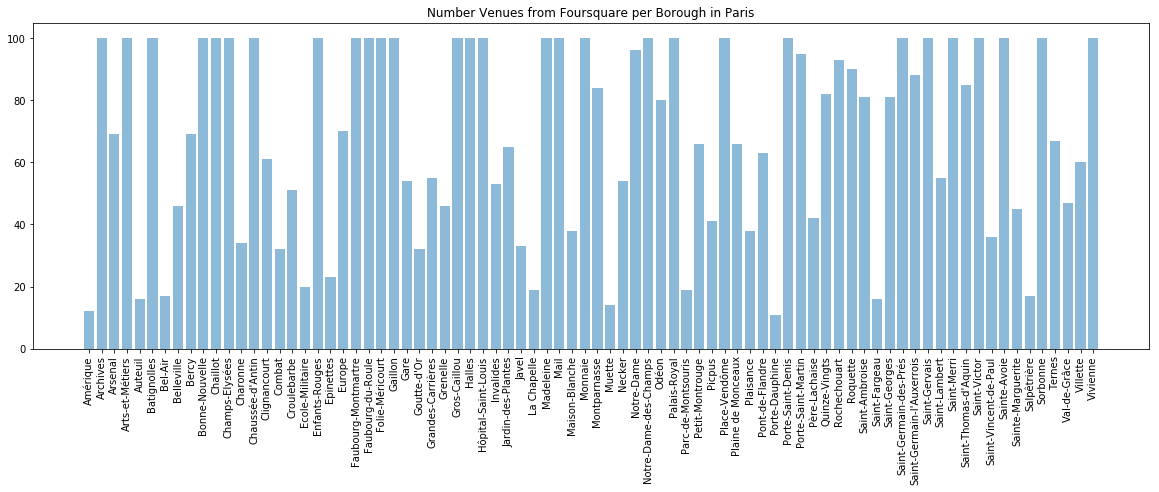

In [58]:
# Check number of venues retrieved by boroughs
df_venues_cnt = paris_venues[['Venue','Neighborhood']]
df_venues_cnt = df_venues_cnt.groupby(['Neighborhood'],as_index=False).count()
df_venues_cnt.sort_values(by=['Neighborhood'],ascending=[True],inplace=True)

# Show number of venues by borough on a bar chart
plt.figure(figsize=(20, 6))
plt.title('Number Venues from Foursquare per Borough in Paris')
plt.bar(df_venues_cnt['Neighborhood'], df_venues_cnt['Venue'], align='center', alpha=0.5)
plt.xticks(df_venues_cnt['Neighborhood'], rotation='vertical')

In [97]:
print('There are {} uniques categories.'.format(len(paris_venues['Venue Category'].unique())))

There are 308 uniques categories.


In [98]:
# Check number of venues by categories
df_venues_cat_cnt = paris_venues[['Venue','Venue Category']]
df_venues_cat_cnt = df_venues_cat_cnt.groupby(['Venue Category'],as_index=False).count()
df_venues_cat_cnt.sort_values(by=['Venue'],ascending=[False],inplace=True)
df_venues_cat_cnt.head(10)

Venue Category  Venue
116    French Restaurant    704
145                Hotel    448
154   Italian Restaurant    207
22                   Bar    169
20                Bakery    168
53                  Café    159
32                Bistro    141
71           Coffee Shop    134
155  Japanese Restaurant    131
221                Plaza    117

### Analyze Each Borough

#### Use One Hot Encoding to Represent Venues / Categories by Borough

In [99]:
# one hot encoding
paris_onehot = pd.get_dummies(paris_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Neighborhood'] = paris_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

print(paris_onehot.shape)
paris_onehot.head()

(5536, 309)


Neighborhood  Accessories Store  Afghan Restaurant  \
0  Saint-Germain-l'Auxerrois                  0                  0   
1  Saint-Germain-l'Auxerrois                  0                  0   
2  Saint-Germain-l'Auxerrois                  0                  0   
3  Saint-Germain-l'Auxerrois                  0                  0   
4  Saint-Germain-l'Auxerrois                  0                  0   

   African Restaurant  Alsatian Restaurant  American Restaurant  Antique Shop  \
0                   0                    0                    0             0   
1                   0                    0                    0             0   
2                   0                    0                    0             0   
3                   0                    0                    0             0   
4                   0                    0                    0             0   

   Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0       0                 0                       0            0           1   
1       0                 0                       0            0           0   
2       0                 0                       0            0           0   
3       0                 0                       0            0           0   
4       0                 0                       0            0           1   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0                    0                     0                 0   
1                    0                     0                 0   
2                    0                     0                 0   
3                    0                     0                 0   
4                    0                     0                 0   

   Athletics & Sports  Auditorium  Auvergne Restaurant  BBQ Joint  Baby Store  \
0                   0           0                    0          0           0   
1                   0           0                    0          0           0   
2                   0           0                    0          0           0   
3                   0           0                    0          0           0   
4                   0           0                    0          0           0   

   Bagel Shop  Bakery  Bank  Bar  Basketball Court  Basque Restaurant  \
0           0       0     0    0                 0                  0   
1           0       0     0    0                 0                  0   
2           0       0     0    0                 0                  0   
3           0       0     0    0                 0                  0   
4           0       0     0    0                 0                  0   

   Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Belgian Restaurant  \
0                0         0            0           0                   0   
1                0         0            0           0                   0   
2                0         0            0           0                   0   
3                0         0            0           0                   0   
4                0         0            0           0                   0   

   Big Box Store  Bike Rental / Bike Share  Bistro  Boat or Ferry  Bookstore  \
0              0                         0       0              0          0   
1              0                         0       0              0          0   
2              0                         0       0              0          0   
3              0                         0       0              0          0   
4              0                         0       0              0          0   

   Botanical Garden  Boutique  Boxing Gym  Brasserie  Brazilian Restaurant  \
0                 0         0           0          0                     0   
1                 0         0           0          0                     0   
2                 0         0           0          0                     0   
3                 0         0           0       

In [100]:
# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
paris_grouped = paris_onehot.groupby('Neighborhood').mean().reset_index()
print(paris_grouped.shape)
paris_grouped

(80, 309)


Neighborhood  Accessories Store  Afghan Restaurant  \
0                    Amérique           0.000000           0.000000   
1                    Archives           0.000000           0.000000   
2                     Arsenal           0.000000           0.000000   
3             Arts-et-Métiers           0.000000           0.000000   
4                     Auteuil           0.000000           0.000000   
5                 Batignolles           0.000000           0.000000   
6                     Bel-Air           0.000000           0.000000   
7                  Belleville           0.000000           0.000000   
8                       Bercy           0.000000           0.000000   
9              Bonne-Nouvelle           0.000000           0.000000   
10                   Chaillot           0.000000           0.000000   
11             Champs-Elysées           0.000000           0.000000   
12                   Charonne           0.000000           0.000000   
13           Chaussée-d'Antin           0.000000           0.000000   
14               Clignancourt           0.000000           0.000000   
15                     Combat           0.000000           0.000000   
16                Croulebarbe           0.000000           0.000000   
17            Ecole-Militaire           0.000000           0.000000   
18             Enfants-Rouges           0.000000           0.000000   
19                  Epinettes           0.000000           0.000000   
20                     Europe           0.000000           0.000000   
21        Faubourg-Montmartre           0.000000           0.000000   
22          Faubourg-du-Roule           0.000000           0.000000   
23            Folie-Méricourt           0.000000           0.000000   
24                    Gaillon           0.000000           0.000000   
25                       Gare           0.000000           0.000000   
26                Goutte-d'Or           0.000000           0.000000   
27          Grandes-Carrières           0.000000           0.000000   
28                   Grenelle           0.000000           0.000000   
29               Gros-Caillou           0.000000           0.000000   
30                     Halles           0.000000           0.000000   
31        Hôpital-Saint-Louis           0.000000           0.000000   
32                  Invalides           0.000000           0.000000   
33         Jardin-des-Plantes           0.000000           0.000000   
34                      Javel           0.000000           0.000000   
35                La Chapelle           0.000000           0.000000   
36                  Madeleine           0.000000           0.000000   
37                       Mail           0.000000           0.000000   
38             Maison-Blanche           0.000000           0.000000   
39                    Monnaie           0.000000           0.000000   
40               Montparnasse           0.000000           0.000000   
41                     Muette           0.000000           0.000000   
42                     Necker           0.000000           0.000000   
43                 Notre-Dame           0.000000           0.000000   
44      Notre-Dame-des-Champs           0.000000           0.000000   
45                      Odéon           0.000000           0.000000   
46               Palais-Royal           0.000000           0.000000   
47         Parc-de-Montsouris           0.000000           0.000000   
48            Petit-Montrouge           0.000000           0.000000   
49                     Picpus           0.000000           0.000000   
50              Place-Vendôme           0.020000           0.000000   
51         Plaine de Monceaux           0.000000           0.000000   
52                  Plaisance           0.000000           0.000000   
53            Pont-de-Flandre           0.016129           0.000000   
54             Porte-Dauphine           0.000000           0.000000   
55          Porte-Saint-Denis           0

#### Top 5 Most Comon Venue Categories in Each Borough

In [101]:
num_top_venues = 5

for hood in paris_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = paris_grouped[paris_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Amérique----
               venue  freq
0        Supermarket  0.14
1  French Restaurant  0.14
2               Café  0.07
3              Plaza  0.07
4               Park  0.07


----Archives----
               venue  freq
0  French Restaurant  0.09
1     Clothing Store  0.08
2        Coffee Shop  0.06
3             Bistro  0.04
4              Hotel  0.04


----Arsenal----
                venue  freq
0   French Restaurant  0.14
1               Hotel  0.08
2  Italian Restaurant  0.04
3               Plaza  0.04
4                Park  0.04


----Arts-et-Métiers----
                venue  freq
0   French Restaurant  0.10
1               Hotel  0.07
2        Cocktail Bar  0.05
3  Italian Restaurant  0.05
4  Chinese Restaurant  0.04


----Auteuil----
                   venue  freq
0           Tennis Court  0.31
1                Stadium  0.12
2                 Garden  0.12
3  Outdoors & Recreation  0.06
4                 Office  0.06


----Batignolles----
                venue  freq
0   Fr

In [110]:
# Create new dataframe and display the top 10 venues for each borough
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = paris_grouped['Neighborhood']

for ind in np.arange(paris_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0         Amérique     French Restaurant           Supermarket   
1         Archives     French Restaurant        Clothing Store   
2          Arsenal     French Restaurant                 Hotel   
3  Arts-et-Métiers     French Restaurant                 Hotel   
4          Auteuil          Tennis Court               Stadium   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                Bakery                  Park         Grocery Store   
1           Coffee Shop                 Hotel                Bistro   
2             Gastropub                 Plaza    Italian Restaurant   
3    Italian Restaurant          Cocktail Bar            Restaurant   
4                Garden            Racecourse                Museum   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                  Café         Metro Station      Asian Restaurant   
1           Pastry Shop           Art Gallery          Cocktail Bar   
2                  Park    Seafood Restaurant      Pedestrian Plaza   
3           Coffee Shop    Chinese Restaurant   Moroccan Restaurant   
4      Botanical Garden     French Restaurant                Office   

   9th Most Common Venue 10th Most Common Venue  
0                 Bistro        Bed & Breakfast  
1           Burger Joint     Italian Restaurant  
2       Tapas Restaurant           Cocktail Bar  
3                    Bar                   Café  
4  Outdoors & Recreation    Sporting Goods Shop

### Cluster Boroughs

In [111]:
# Run k-means to cluster the neighborhood into 5 clusters.
# set number of clusters
kclusters = 7

paris_grouped_clustering = paris_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 2, 2, 4, 1, 3, 5, 3, 2], dtype=int32)

In [112]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

paris_merged = df_boroughs

# merge paris_grouped with toronto_data to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='name')

paris_merged.head()

id                       name  district                        geom_x_y  \
78   1  Saint-Germain-l'Auxerrois         1  [48.8606501352, 2.33491032928]   
65   2                     Halles         1  [48.8622891081, 2.34489885831]   
62   3               Palais-Royal         1  [48.8646599781, 2.33630891897]   
24   4              Place-Vendôme         1  [48.8670185906, 2.32858166493]   
40   5                    Gaillon         2  [48.8693066381, 2.33343180766]   

                                              polygon   latitude  longitude  \
78  [[[2.344593389828428, 48.85404991486193], [2.3...  48.860650   2.334910   
65  [[[2.349365804803003, 48.86057567227664], [2.3...  48.862289   2.344899   
62  [[[2.339465868602756, 48.86213531210705], [2.3...  48.864660   2.336309   
24  [[[2.3319449693932333, 48.86491285292421], [2....  48.867019   2.328582   
40  [[[2.336320212305948, 48.8679713890312], [2.33...  48.869307   2.333432   

    Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
78               2     French Restaurant                 Hotel   
65               2     French Restaurant                Bakery   
62               3   Japanese Restaurant     French Restaurant   
24               6     French Restaurant                 Hotel   
40               3                 Hotel   Japanese Restaurant   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
78                  Café                 Plaza           Coffee Shop   
65                 Hotel                  Café           Coffee Shop   
62           Coffee Shop                 Hotel                 Plaza   
24         Jewelry Store              Boutique   Japanese Restaurant   
40     French Restaurant    Italian Restaurant        Sandwich Place   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
78         Historic Site                   Bar            Art Museum   
65        Clothing Store                 Plaza    Italian Restaurant   
62                  Café      Ramen Restaurant    Italian Restaurant   
24        Chocolate Shop          Dessert Shop             Bookstore   
40             Bookstore                 Plaza         Jewelry Store   

   9th Most Common Venue 10th Most Common Venue  
78      Ramen Restaurant                Exhibit  
65          Burger Joint             Restaurant  
62         Historic Site                 Bistro  
24             Hotel Bar                  Plaza  
40                Bakery      Korean Restaurant

In [113]:
clusters_cnt = paris_merged.groupby(['Cluster Labels'],as_index=False).count()
clusters_cnt[['Cluster Labels','id']]

Cluster Labels  id
0               0   7
1               1  17
2               2  22
3               3   8
4               4   1
5               5  12
6               6  13

In [125]:
# create map
map_clusters = folium.Map(location=[48.861472, 2.347581], zoom_start=13, tiles='cartodbpositron')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

map_clusters.choropleth(
    geo_data=Paris_boroughs,
    data=df_borough_mean,
    columns=['borough_name', 'price_sqm'],
    key_on="feature.properties.l_qu",
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.2,
    legend_name = 'Housing Sales Price per Sqm per Borough (2018 - 2019)'
)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['latitude'], paris_merged['longitude'], paris_merged['name'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)

map_clusters

### Examine Clusters

#### First Cluster

In [116]:
paris_merged.loc[paris_merged['Cluster Labels'] == 0, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

name   latitude  longitude  Cluster Labels  \
9   Maison-Blanche  48.823128   2.352433               0   
36  Porte-Dauphine  48.871766   2.271918               0   
70     Goutte-d'Or  48.892138   2.355536               0   
55     La Chapelle  48.894012   2.364387               0   
41        Amérique  48.881638   2.395440               0   
35   Saint-Fargeau  48.871035   2.406172               0   
26        Charonne  48.854760   2.407430               0   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
9      French Restaurant                 Plaza                Bakery   
36          Tennis Court  Gym / Fitness Center                  Park   
70                   Bar      Asian Restaurant           Supermarket   
55    Chinese Restaurant          Soccer Field           Supermarket   
41     French Restaurant           Supermarket                Bakery   
35           Supermarket                Bakery                  Café   
26           Supermarket                   Bar                 Hotel   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
9     Chinese Restaurant                Bistro                  Café   
36                  Café       College Theater                 Plaza   
70    Chinese Restaurant  Fast Food Restaurant               Theater   
55       Thai Restaurant                Garden              Gym Pool   
41                  Park         Grocery Store                  Café   
35                 Diner          Tram Station  Arts & Entertainment   
26  Fast Food Restaurant           Pizza Place                  Café   

    7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
9       Food & Drink Shop            Beer Store                  Park   
36            Supermarket           Pizza Place         Metro Station   
70         Farmers Market      Sushi Restaurant       Thai Restaurant   
55  Vietnamese Restaurant     French Restaurant        Farmers Market   
41          Metro Station      Asian Restaurant                Bistro   
35            Pizza Place     French Restaurant                 Plaza   
26    Japanese Restaurant          Tram Station              Bus Stop   

   10th Most Common Venue  
9                   Diner  
36          Grocery Store  
70                 Bakery  
55     Mexican Restaurant  
41        Bed & Breakfast  
35    Japanese Restaurant  
26      French Restaurant

Residential area with supermarkets, cafes, restaurants, fast foods and parks

#### Second Cluster

In [117]:
paris_merged.loc[paris_merged['Cluster Labels'] == 1, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

name   latitude  longitude  Cluster Labels  \
33            Saint-Victor  48.847664   2.354093               1   
46   Notre-Dame-des-Champs  48.846428   2.327357               1   
16  Saint-Germain-des-Prés  48.855289   2.333657               1   
76    Saint-Thomas-d'Aquin  48.855263   2.325588               1   
38               Invalides  48.858515   2.316445               1   
58            Gros-Caillou  48.858300   2.301542               1   
28                  Europe  48.878148   2.317175               1   
63            Rochechouart  48.879812   2.344861               1   
17   Saint-Vincent-de-Paul  48.880735   2.357471               1   
29       Sainte-Marguerite  48.852097   2.388765               1   
10             Croulebarbe  48.833734   2.347673               1   
31           Saint-Lambert  48.834294   2.296920               1   
27                   Javel  48.839060   2.278076               1   
45                  Ternes  48.881178   2.289964               1   
32             Batignolles  48.888482   2.313856               1   
37       Grandes-Carrières  48.892578   2.334363               1   
25                  Combat  48.878639   2.380127               1   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
33     French Restaurant                 Hotel                Bakery   
46     French Restaurant                 Hotel                Bakery   
16     French Restaurant                 Hotel    Italian Restaurant   
76     French Restaurant                 Hotel                  Café   
38     French Restaurant                 Hotel                 Plaza   
58     French Restaurant    Italian Restaurant                 Hotel   
28     French Restaurant                 Hotel           Pizza Place   
63     French Restaurant                 Hotel                Bakery   
17     Indian Restaurant     French Restaurant                 Hotel   
29     French Restaurant                   Bar                 Hotel   
10     French Restaurant      Sushi Restaurant                   Bar   
31     French Restaurant                 Hotel       Thai Restaurant   
27     French Restaurant                 Hotel           Pizza Place   
45     French Restaurant    Italian Restaurant                 Hotel   
32     French Restaurant                 Hotel    Italian Restaurant   
37     French Restaurant                   Bar            Restaurant   
25     French Restaurant                   Bar                  Park   

   4th Most Common Venue     5th Most Common Venue  \
33                Museum        Italian Restaurant   
46   Japanese Restaurant                    Bistro   
16                  Café                  Wine Bar   
76                Bakery               Coffee Shop   
38                  Café            History Museum   
58                  Café               Coffee Shop   
28        Sandwich Place           Thai Restaurant   
63    Italian Restaurant               Coffee Shop   
17                Hostel        African Restaurant   
29                Bistro      Gym / Fitness Center   
10        Sandwich Place                    Bakery   
31                Bakery        Italian Restaurant   
27                  Café  Bike Rental / Bike Share   
45    Seafood Restaurant       Moroccan Restaurant   
32                   Bar                    Bistro   
37                 Hotel        Italian Restaurant   
25    Italian Restaurant                Restaurant   

            6th Most Common Venue 7th Most Common Venue  \
33            Japanese Restaurant                  Park   
46             Italian Restaurant                  Café   
16                 Sandwich Place                 Plaza   
76            American Restaurant        Sandwich Place   
38                           Park            Art Museum   
58                         Bakery        Ice Cream Shop   
28                         Bakery                   Pub   
63  Vegetarian / Vegan Restaurant                   Bar

Touristic area with many hotels, restaurants, places to go out, parks, museums and few shops

#### Third Cluster

In [118]:
paris_merged.loc[paris_merged['Cluster Labels'] == 2, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

name   latitude  longitude  Cluster Labels  \
78  Saint-Germain-l'Auxerrois  48.860650   2.334910               2   
65                     Halles  48.862289   2.344899               2   
14                   Vivienne  48.869100   2.339461               2   
66                       Mail  48.868008   2.344699               2   
67             Bonne-Nouvelle  48.867150   2.350080               2   
71            Arts-et-Métiers  48.866470   2.357083               2   
15             Enfants-Rouges  48.863887   2.363123               2   
72                   Archives  48.859192   2.363205               2   
42               Sainte-Avoie  48.862557   2.354852               2   
56                Saint-Merri  48.858521   2.351667               2   
75              Saint-Gervais  48.855719   2.358162               2   
0                     Arsenal  48.851585   2.364768               2   
57                 Notre-Dame  48.852896   2.352775               2   
1          Jardin-des-Plantes  48.841940   2.356894               2   
59                   Sorbonne  48.849045   2.345747               2   
6                     Monnaie  48.854384   2.340035               2   
7                       Odéon  48.847801   2.336339               2   
8              Champs-Elysées  48.867074   2.308652               2   
61           Chaussée-d'Antin  48.873547   2.332269               2   
39        Faubourg-Montmartre  48.873935   2.343253               2   
2          Porte-Saint-Martin  48.871245   2.361504               2   
74              Quinze-Vingts  48.846916   2.374402               2   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
78     French Restaurant                 Hotel                  Café   
65     French Restaurant                Bakery                 Hotel   
14     French Restaurant   Japanese Restaurant    Italian Restaurant   
66          Cocktail Bar     French Restaurant                Bakery   
67          Cocktail Bar     French Restaurant           Coffee Shop   
71     French Restaurant                 Hotel    Italian Restaurant   
15                  Café                Bistro           Coffee Shop   
72     French Restaurant        Clothing Store           Coffee Shop   
42     French Restaurant                  Café            Restaurant   
56     French Restaurant           Art Gallery                 Plaza   
75     French Restaurant           Pastry Shop        Clothing Store   
0      French Restaurant                 Hotel             Gastropub   
57     French Restaurant                 Plaza                Bakery   
1      French Restaurant                 Hotel                Garden   
59                 Hotel     French Restaurant                 Plaza   
6      French Restaurant                 Hotel                 Plaza   
7      French Restaurant                 Hotel                Bistro   
8      French Restaurant                 Hotel              Boutique   
61     French Restaurant                 Hotel           Coffee Shop   
39     French Restaurant                 Hotel                Bistro   
2            Coffee Shop     French Restaurant          Cocktail Bar   
74     French Restaurant           Coffee Shop        Sandwich Place   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
78                 Plaza           Coffee Shop         Historic Site   
65                  Café           Coffee Shop        Clothing Store   
14                Bistro                  Café     Korean Restaurant   
66    Italian Restaurant           Salad Place            Restaurant   
67              Wine Bar                 Hotel                   Bar   
71          Cocktail Bar            Restaurant           Coffee Shop   
15            Restaurant              Wine Bar        Clothing Store   
72                 Hotel                Bistro           Pastry Shop   
42    Chinese Restaurant           Coffee Shop                Bakery   
56           C

Shopping and touristic area with hotels, restaurants, many shops, museums and art galleries

#### Fourth Cluster

In [119]:
paris_merged.loc[paris_merged['Cluster Labels'] == 3, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

name   latitude  longitude  Cluster Labels  \
62        Palais-Royal  48.864660   2.336309               3   
40             Gaillon  48.869307   2.333432               3   
19             Bel-Air  48.840247   2.407823               3   
64               Bercy  48.835209   2.386210               3   
68                Gare  48.827527   2.372398               3   
30  Parc-de-Montsouris  48.823453   2.337070               3   
49              Muette  48.860060   2.265865               3   
48     Pont-de-Flandre  48.895556   2.384777               3   

   1st Most Common Venue                     2nd Most Common Venue  \
62   Japanese Restaurant                         French Restaurant   
40                 Hotel                       Japanese Restaurant   
19          Tram Station  Residential Building (Apartment / Condo)   
64                 Hotel                        Italian Restaurant   
68                 Hotel                                      Café   
30    Italian Restaurant                                   Theater   
49                 Plaza                                    Garden   
48                 Hotel                                Restaurant   

   3rd Most Common Venue    4th Most Common Venue 5th Most Common Venue  \
62           Coffee Shop                    Hotel                 Plaza   
40     French Restaurant       Italian Restaurant        Sandwich Place   
19                 Track  Fruit & Vegetable Store                Bistro   
64        Breakfast Spot                   Museum                Bakery   
68   Japanese Restaurant    Vietnamese Restaurant        Sandwich Place   
30     French Restaurant       Chinese Restaurant      Sushi Restaurant   
49                Castle              Coffee Shop             Cafeteria   
48     French Restaurant         Asian Restaurant   Japanese Restaurant   

        6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
62                       Café      Ramen Restaurant    Italian Restaurant   
40                  Bookstore                 Plaza         Jewelry Store   
19               Dance Studio        Sandwich Place     French Restaurant   
64          French Restaurant              Wine Bar           Supermarket   
68            Thai Restaurant     French Restaurant  Fast Food Restaurant   
30  Middle Eastern Restaurant      Kebab Restaurant                 Diner   
49                   Bus Stop           Bus Station            Art Museum   
48                       Café                Bakery         Movie Theater   

   9th Most Common Venue 10th Most Common Venue  
62         Historic Site                 Bistro  
40                Bakery      Korean Restaurant  
19                  Park      Food & Drink Shop  
64     Convenience Store       Sushi Restaurant  
68    Italian Restaurant            Coffee Shop  
30            Restaurant                    Gym  
49    Italian Restaurant                   Park  
48          Tram Station              Rock Club

Area with many hotels, international restaurants and theaters

#### Fifth Cluster

In [120]:
paris_merged.loc[paris_merged['Cluster Labels'] == 4, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

name   latitude  longitude  Cluster Labels 1st Most Common Venue  \
13  Auteuil  48.850622   2.252277               4          Tennis Court   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
13               Stadium                Garden            Racecourse   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
13                Museum      Botanical Garden     French Restaurant   

   8th Most Common Venue  9th Most Common Venue 10th Most Common Venue  
13                Office  Outdoors & Recreation    Sporting Goods Shop

Recreation area with venues for outdoor activities, sport and museums

#### Sixth Cluster

In [121]:
paris_merged.loc[paris_merged['Cluster Labels'] == 5, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

name   latitude  longitude  Cluster Labels  \
52         Val-de-Grâce  48.841684   2.343861               5   
77    Porte-Saint-Denis  48.873618   2.352283               5   
43  Hôpital-Saint-Louis  48.876008   2.368123               5   
22      Folie-Méricourt  48.867403   2.372965               5   
18       Saint-Ambroise  48.862345   2.376118               5   
3              Roquette  48.857064   2.380364               5   
23          Salpêtrière  48.837406   2.363319               5   
51            Epinettes  48.894943   2.321119               5   
69         Clignancourt  48.891668   2.345979               5   
79             Villette  48.887661   2.374468               5   
44           Belleville  48.871531   2.387549               5   
54        Père-Lachaise  48.863719   2.395273               5   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
52     French Restaurant                 Hotel                   Bar   
77     French Restaurant           Pizza Place           Coffee Shop   
43     French Restaurant                   Bar              Wine Bar   
22     French Restaurant                   Bar            Restaurant   
18     French Restaurant                   Bar            Restaurant   
3      French Restaurant                   Bar                Bistro   
23     French Restaurant     Indian Restaurant           Pizza Place   
51     French Restaurant                 Hotel           Supermarket   
69     French Restaurant                   Bar           Pizza Place   
79                   Bar                  Café                 Hotel   
44                   Bar     French Restaurant                  Café   
54                Bakery                   Bar                Bistro   

       4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
52          Asian Restaurant        Science Museum                  Café   
77                     Hotel                   Bar                Bakery   
43                      Café           Coffee Shop      Asian Restaurant   
22                    Bakery                 Hotel    Italian Restaurant   
18               Coffee Shop                Bistro                Bakery   
3         Italian Restaurant          Cocktail Bar           Pastry Shop   
23  Mediterranean Restaurant                   Bar                Bakery   
51       Japanese Restaurant            Restaurant    Turkish Restaurant   
69                      Café                Bistro            Restaurant   
79         French Restaurant           Supermarket             Multiplex   
44       Japanese Restaurant                 Hotel            Beer Store   
54       Japanese Restaurant     French Restaurant                 Plaza   

        7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
52                     Bistro              Creperie    Italian Restaurant   
77        Japanese Restaurant          Burger Joint     Korean Restaurant   
43                     Bistro           Pizza Place    Italian Restaurant   
22                   Creperie                   Gym                Bistro   
18               Cocktail Bar    Italian Restaurant   Japanese Restaurant   
3                 Supermarket   Japanese Restaurant                  Café   
23  Cajun / Creole Restaurant  Gym / Fitness Center    Chinese Restaurant   
51           Sushi Restaurant      Pedestrian Plaza  Gym / Fitness Center   
69                Cheese Shop           Coffee Shop                 Hotel   
79                 Food Truck  Fast Food Restaurant    Italian Restaurant   
44                    Theater       Thai Restaurant    Chinese Restaurant   
54                  Wine Shop                  Park    Italian Restaurant   

   10th Most Common Venue  
52    Indie Movie Theater  
77                 Bistro  
43        Thai Restaurant  
22              Juice Bar  
18                   Café  
3             Pizza Place  
23       Sushi Restaurant  
51   Ethiopian Restau

Nightlife area with many bars, restaurants, bistros, cafes

#### Seventh Cluster

In [122]:
paris_merged.loc[paris_merged['Cluster Labels'] == 6, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

name   latitude  longitude  Cluster Labels  \
24       Place-Vendôme  48.867019   2.328582               6   
11     Ecole-Militaire  48.850359   2.311031               6   
73   Faubourg-du-Roule  48.874136   2.304119               6   
34           Madeleine  48.871265   2.320053               6   
60       Saint-Georges  48.879934   2.332850               6   
4               Picpus  48.839388   2.395743               6   
20        Montparnasse  48.837623   2.331784               6   
47     Petit-Montrouge  48.826653   2.326437               6   
5            Plaisance  48.830317   2.315305               6   
53              Necker  48.842711   2.310777               6   
12            Grenelle  48.850172   2.291853               6   
50            Chaillot  48.868434   2.291679               6   
21  Plaine de Monceaux  48.885044   2.302910               6   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
24     French Restaurant                 Hotel         Jewelry Store   
11                 Hotel     French Restaurant                 Plaza   
73                 Hotel     French Restaurant        Clothing Store   
34                 Hotel     French Restaurant              Boutique   
60                 Hotel     French Restaurant    Italian Restaurant   
4                  Hotel     French Restaurant           Supermarket   
20     French Restaurant                 Hotel                   Bar   
47                 Hotel     French Restaurant           Supermarket   
5                  Hotel     French Restaurant                Bistro   
53     French Restaurant                 Hotel                  Café   
12                 Hotel     French Restaurant   Japanese Restaurant   
50                 Hotel     French Restaurant    Italian Restaurant   
21     French Restaurant                 Hotel    Italian Restaurant   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
24              Boutique   Japanese Restaurant        Chocolate Shop   
11                Bistro                Garden          Dessert Shop   
73        Cosmetics Shop    Italian Restaurant      Department Store   
34         Women's Store          Gourmet Shop        Clothing Store   
60          Cocktail Bar                 Plaza                Bakery   
4                 Bistro                  Café    Chinese Restaurant   
20                Bakery    Italian Restaurant                Bistro   
47    Italian Restaurant      Sushi Restaurant        Discount Store   
5                    Bar   Japanese Restaurant         Grocery Store   
53                Bakery     Korean Restaurant  Gym / Fitness Center   
12                Bistro                Bakery     Indian Restaurant   
50                  Café                 Plaza                Bakery   
21                Bakery      Asian Restaurant                 Plaza   

    7th Most Common Venue 8th Most Common Venue       9th Most Common Venue  \
24           Dessert Shop             Bookstore                   Hotel Bar   
11            Pastry Shop                  Café              Farmers Market   
73    Japanese Restaurant         Jewelry Store            Asian Restaurant   
34           Dessert Shop             Hotel Bar                     Theater   
60  Vietnamese Restaurant               Theater                 Comedy Club   
4                  Bakery        Ice Cream Shop                    Beer Bar   
20       Sushi Restaurant                  Café                        Park   
47                 Bakery                Bistro              Sandwich Place   
5                     Gym     Food & Drink Shop  Modern European Restaurant   
53           Dessert Shop         Metro Station                      Bistro   
12            Coffee Shop    Italian Restaurant        Gym / Fitness Center   
50             Art Museum                   Bar                         Pub   
21                 Bistro            Restaurant                        Café 

Shopping areas with many shops, hotels, restaurants

### Map with Price per sqm and nb of sales

In [69]:
# Add location data in dataframe
df_borough_cnt.columns = ['borough_name','cnt']
df_temp = df_borough_cnt.join(df_boroughs.set_index('name'), on='borough_name')
df_borough_cnt = df_temp[['borough_name','cnt','latitude','longitude']]

# generate choropleth map using the price per sqm for all Paris boroughs
paris_map5 = folium.Map(location=[48.861472, 2.347581], zoom_start=13, tiles='cartodbpositron')
paris_map5.choropleth(
    geo_data=Paris_boroughs,
    data=df_borough_mean,
    columns=['borough_name', 'price_sqm'],
    key_on="feature.properties.l_qu",
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.2,
    legend_name = 'Housing Sales Price per Sqm per Borough (2018 - 2019)'
)

# add markers to the map
markers_colors = []
for lat, lon, name, cnt in zip(df_borough_cnt['latitude'], df_borough_cnt['longitude'], df_borough_cnt['borough_name'], df_borough_cnt['cnt']):
    label = folium.Popup(str(name) + ' No of Sales ' + str(cnt), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=cnt/150,
        popup=label,
        color='#3186cc',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.9).add_to(paris_map5)
    
# display map
paris_map5